# 循环神经网络

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from tensorflow.keras import layers, Model, Input, Sequential, datasets
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(gpu)
except RuntimeError as e:
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 序列
具有先后顺序的数据一般叫作序列(Sequence). 我们把文字编码为数值的过程叫作**Word Embedding**.

one-hot编码的优缺点:
- 简单直观，编码过程不需要学习和训练;
- 但高维度而且极其稀疏的，大量的位置为0，计算效率较低, 忽略了单词先天具有的语义相关性;

余弦相关度(Cosine similarity), 衡量词向量(word vector)之间相关度:
$$similarity(a, b) \triangleq \frac {a \cdot b}{|a|\cdot|b|}$$

### Embedding层
单词的表示层叫作Embedding层, 负责把单词编码为某个词向量𝒗

$$v = f_{\theta}(i|N_{vocab}, n)$$
单词数量记为$N_{vocab}$, $v的长度为n$, $i$表示单词编号, 如2 表示“I”，3 表示“me”等.

In [ ]:
x = tf.range(10)  # 代表10个不同单词的编码

x = tf.random.shuffle(x)
# 10个单词, 每个单词用长度4 的向量表示
net = layers.Embedding(10, 4)
out = net(x)
out

In [ ]:
net.get_weights()

### 预训练的词向量

应用的比较广泛的预训练模型:Word2Vec 和GloVe模型.利用已预训练好的模型参数初始化Embedding层.

In [4]:
def load_embed(path):
    # 建立映射关系: 单词: 词向量(长度50))
    embedding_map = {}
    with open(path, encoding='utf8') as f:
        for line in f.readlines():
            l = line.split()
            word = l[0]
            coefs = np.asarray(l[1:], dtype='float32')
            embedding_map[word] = coefs
    return embedding_map

In [5]:
embedding_map = load_embed('glove.6B.50d.txt')
print('Found %s word vectors.' % len(embedding_map))

Found 400000 word vectors.


In [ ]:
embedding_map['the']

### 20newsgroups 测试

In [ ]:
from sklearn import datasets
# 加载20newsgroups数据集
news20 = datasets.fetch_20newsgroups()

In [ ]:
news20.keys()

In [ ]:
category = news20.target_names  # 一共20类不同的新闻
category

In [ ]:
labels = news20['target']  # 每条新闻分属的类别

In [ ]:
len(news20['data'])

In [ ]:
news20['data'][0], category[news20['target'][0]]

In [ ]:
MAX_NUM_WORDS = 20000  # 最多保留 20000-1 个不同的单词
MAX_SEQUENCE_LENGTH = 1000  # 每个序列长度
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 50  # 用50维向量表示一个单词

In [ ]:
Tokenizer?

In [ ]:
# vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)  #  Only the most common `num_words-1` words will be kept.

In [ ]:
# Updates internal vocabulary based on a list of texts
tokenizer.fit_on_texts(news20['data'])
sequences = tokenizer.texts_to_sequences(news20['data'])  # 语句 -> 单词序列号组成的sequences

In [ ]:
# matrix = tokenizer.texts_to_matrix(news20['data'])
# matrix.shape  # (11314, 20000)  稀疏矩阵

In [ ]:
sequences[0]

In [ ]:
# 将sequences 转成文本list
# tokenizer.sequences_to_texts(sequences)

In [ ]:
# 将单词映射为 index
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
word_index_list = list(word_index.items())

In [ ]:
# 从1开始编码 用0代表填充
word_index_list[:10]  # news20group 出现频率最高的10个单词

In [ ]:
word_index_list[19998]

In [ ]:
# Pads sequences to the same length.
pad_sequences?

In [ ]:
# 每条新闻都被编码成 等长的 用数字表示的 序列
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
data.shape

In [ ]:
np.max(data), np.min(data) # 

In [ ]:
from sklearn.model_selection import train_test_split

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=VALIDATION_SPLIT, random_state=0) 

In [ ]:
X_train.shape, y_test.shape

In [ ]:
# 将 单词序号-> 单词向量(长度50)
num_words = min(MAX_NUM_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

applied_vec_count = 0
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    # 根据glove.6B.50d 将单词转为词向量
    embedding_vector = embedding_map.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        applied_vec_count += 1
print(applied_vec_count, embedding_matrix.shape)

In [ ]:
# new20group中最常用的19999 词向量 + 填充 + unknow
embedding_matrix.shape

In [ ]:
embedding_matrix[-1]

In [ ]:
layers.Embedding?

In [ ]:
embedding_layer = layers.Embedding(
    num_words, EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [ ]:
sequence_input = Input((MAX_SEQUENCE_LENGTH, ), dtype=tf.int32)
embedded_sequences = embedding_layer(sequence_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)
preds = layers.Dense(len(category), activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)

In [ ]:
model.summary()

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train, batch_size=128, epochs=15, validation_data=(X_test, y_test))

In [ ]:
plt.plot(np.linspace(1, 15, 15), hist.history['loss'], label='loss')
plt.plot(np.linspace(1, 15, 15), hist.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
plt.plot(np.linspace(1, 15, 15), hist.history['accuracy'], label='accuracy')
plt.plot(np.linspace(1, 15, 15), hist.history['val_accuracy'], label='val_accuracy')
plt.legend()

## 循环神经网络


$$h_t = \sigma(W_{xh}x_t + W_{hh}h_{t-1} + b)$$
在每个时间戳$t$, 网络层接受当前时间戳的输入$x_t$和上一个时间戳的网络状态向量$h_{t-1}$,经过
$$h_t = f_{\theta}(h_{t-1}, x_t)$$
变换后得到当前时间戳的新状态向量$h_t$. 在每个时间戳上, 网络层均有输出$o_t = g_{\phi}(h_t)$

对于这种网络结构，我们把它叫做循环网络结构(Recurrent Neural Network，简称RNN)。

在循环神经网络中，激活函数更多地采用tanh 函数.并且可以选择不使用偏执𝒃来进一步减少参数量。

状态向量$h_t$可以直接用作输出，即$o_t = h_t$，也可以对$t$做一个简单的线性变换.

## 梯度传播

参数$W_{hh}$的梯度计算
$$\frac {\partial L}{\partial W_{hh}} = \sum_{i=1}^t \frac {\partial L}{\partial o_t}
\frac {\partial o_t}{\partial h_t} \frac {\partial h_t}{\partial h_i}
\frac {\partial^+ h_i}{\partial W_{hh}}
$$
其中
$$\frac {\partial^+ h_i}{\partial W_{hh}} = \frac {\partial \sigma(W_{xh}x_t + W_{hh}h_{t-1} +b)}{\partial W_{hh}}$$
只考虑一个时间戳的梯度传播, 即"直接"偏导数.

$$
\frac {\partial h_t}{\partial h_i} = 
\frac {\partial h_t}{\partial h_{t-1}}
\frac {\partial h_{t-1}}{\partial h_{t-2}}
\cdots
\frac {\partial h_{i+1}}{\partial h_i}
= \prod_{k=i}^{t-1}\frac {\partial h_{k+1}}{\partial h_{k}} $$


$$\frac {\partial h_{k+1}}{\partial h_{k}}
= W^T_{hh}diag(\sigma'(h_{k+1}))$$

所以$$\frac {\partial h_t}{\partial h_i} = \prod_{j=i}^{t-1}diag(\sigma'(W_{xh}x_{j+1} + W_{hh}h_j + b))W_{hh}$$

其中包含雅克比矩阵和$W_{hh}$的连乘运算, 容易出现梯度消失(激活函数使用sigmoid或tanh时)或梯度爆炸(使用ReLU)


## RNN层的使用

- SimpleRNNCell: 完成了一个时间戳的前向运算($\sigma(W_{xh}x_t + W_{hh}h_{t-1} +b)$)
- SimpleRNN: 基于Cell 层实现的，它在内部已经完成了多个时间戳的循环运算，

### SimpleRNNCell

In [ ]:
layers.SimpleRNNCell?

In [ ]:
cell = layers.SimpleRNNCell(3)  # 内存向量h长度 3
cell.build(input_shape=(None, 4))  # 输入x特征长度4
cell.trainable_variables  # W_xh ,  W_hh, b

前向运算
$$o_t, [h_t] = Cell(x_t, [h_{t-1})$$

In [ ]:
# 初始化状态向量，用列表包裹，统一格式
h0 = [tf.zeros([4, 64])]

# (b, word_num, word_vec_length)
x = tf.random.normal([4, 80, 100])
xt = x[:, 0, :]  # 所有句子的第一个单词

cell = layers.SimpleRNNCell(64)
out1, h1 = cell(xt, h0)  # h1用list包裹, out1没有经过变换 = h1

In [ ]:
out.shape, h1[0].shape

In [ ]:
print(id(out), id(h1[0]))  # 状态向量直接作为输出向量

In [ ]:
h = h0
for x_t in tf.unstack(x, axis=1):  # 时间维度解开, 按时间输入单词
    out, h = cell(x_t, h)
out = out  # 只取最后时间戳的输出  N->1

In [ ]:
# 2层循环神经网络
x = tf.random.normal([4, 80, 100])
xt = x[:, 0, :]
cell0 = layers.SimpleRNNCell(64)
cell1 = layers.SimpleRNNCell(64)
# 2个cell的初始状态
h0 = [tf.zeros((4, 64))]
h1 = [tf.zeros((4, 64))]

# 一个时间戳上完成2层传播在到下一个时间戳
for xt in tf.unstack(x, axis=1):
    out0, h0 = cell0(xt, h0)
    
    out1, h1 = cell1(out0, h1)

In [ ]:
# 先完成第一层所有时间的传播再完成第二层所有时间的传播
middle_seqences = []

for xt in tf.unstack(x, axis=1):
    out0, h0 = cell0(xt, h0)
    middle_seqences.append(out0)

for xt in middle_seqences:
    out1, h1 = cell1(xt, h1)

### SimpleRNN

In [ ]:
# SimpleRNN  完成多个时间戳的计算
layer = layers.SimpleRNN(64)
x = tf.random.normal([4, 80, 100])
out = layer(x)
out.shape

In [ ]:
# 返回所有时间戳上的输出
layer = layers.SimpleRNN(64, return_sequences=True)
out = layer(x)
out.shape

In [ ]:
# 多层RNN网络
net = Sequential([
    # 除最末层外，都需要返回所有时间戳的输出，用作下一层的输入
    layers.SimpleRNN(64, return_sequences=True),
    layers.SimpleRNN(64, return_sequences=True),
    layers.SimpleRNN(64)
])

In [ ]:
out = net(x)
out.shape

## RNN情感分类
imdb评分>7 为1 positive; IMDB 评级<5 的用户评价标注为0 

利用第2 层RNN 层的最后时间戳的状态向量h, 作为句子的全局语义特征表示, 送入全连接分类网络

In [6]:
BATCH_SIZE = 128
TOTAL_WORDS = 10000  # 词汇表大小
MAX_REVIEW_LEN = 80  # 句子长度
EMBEDDING_LEN = 50  # 词向量长度

In [ ]:
datasets.imdb.load_data?

In [7]:
# imdb数据集

(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(
    num_words=TOTAL_WORDS)

In [8]:
print(X_train.shape, len(X_train[0]), y_train.shape)  # X 不等长的list 组成的array

(25000,) 218 (25000,)


In [9]:
print(X_test.shape, len(X_test[0]), y_test.shape)

(25000,) 68 (25000,)


In [10]:
# 编码表
word_index = datasets.imdb.get_word_index()

pre_10 = list(word_index.items())[:10]
for item in pre_10:  
    print(item)  # 单词-数字

1646592/1641221 [==============================] - 40s 24us/step
('fawn', 34701)
('tsukino', 52006)
('nunnery', 52007)
('sonja', 16816)
('vani', 63951)
('woods', 1408)
('spiders', 16115)
('hanging', 2345)
('woody', 2289)
('trawling', 52008)


In [11]:
print(f'total {len(word_index)} unique words')

total 88584 unique words


In [12]:
# 添加标志位
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0  # 表示填充
word_index["<START>"] = 1  # 表示起始
word_index["<UNK>"] = 2  # 表示未知单词
word_index["<UNUSED>"] = 3

# 翻转
index_word = dict([(v, k) for k, v in word_index.items()]) 

In [13]:
def decode_review(text):
    # 数字序列 -> 文本
    return ' '.join([index_word.get(i, '?') for i in text])


In [14]:
# 截断 填充 成等长的序列
X_train = pad_sequences(X_train, maxlen=MAX_REVIEW_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_REVIEW_LEN)

In [15]:
decode_review(X_train[0])

"that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was someone's life after all that was shared with us all"

In [16]:
decode_review(X_test[0])

"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite <UNK> so all you madison fans give this a miss"

In [17]:
train_db = tf.data.Dataset.from_tensor_slices(  # 舍弃最后一组 
    (X_train, y_train)).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)
test_db = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)).shuffle(1000).batch(BATCH_SIZE, drop_remainder=True)

In [18]:
sample = next(iter(train_db))
sample[0], sample[1]

(<tf.Tensor: shape=(128, 80), dtype=int32, numpy=
 array([[   2,   19,    6, ...,    4,  673,  394],
        [  10,    4,  226, ...,   10,    4, 8405],
        [  16, 3444,  402, ...,   23,   61, 7698],
        ...,
        [   0,    0,    0, ...,   22,    7, 7553],
        [ 184,   76,  307, ...,    6, 3322, 1690],
        [5167,   73,  224, ...,  111,  128,  663]], dtype=int32)>,
 <tf.Tensor: shape=(128,), dtype=int64, numpy=
 array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0])>)

In [19]:
embedding_map = load_embed('glove.6B.100d.txt')
print('Found %s word vectors.' % len(embedding_map))

FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

In [20]:
# 将 单词序号-> 单词向量(长度50)
num_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_LEN))

applied_vec_count = 0
for word, i in word_index.items():
    if i >= TOTAL_WORDS:
        continue
    # 根据glove.6B.50d 将单词转为词向量
    embedding_vector = embedding_map.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        applied_vec_count += 1
print(applied_vec_count, embedding_matrix.shape)

9793 (10000, 50)


In [21]:
class MyRNN(Model):
    def __init__(self, units):
        super().__init__()
        # 初始状态向量
        self.state0 = [tf.zeros([BATCH_SIZE, units])]
        self.state1 = [tf.zeros([BATCH_SIZE, units])]
        # 词嵌入层
        self.embedding = layers.Embedding(TOTAL_WORDS, EMBEDDING_LEN,
                                          input_length=MAX_REVIEW_LEN,
#                                           weights=[embedding_matrix],
#                                          trainable=False
                                         )
        # RNNCell
#         self.runcell0 = layers.SimpleRNNCell(units, dropout=0.5)
#         self.runcell1 = layers.SimpleRNNCell(units, dropout=0.5)
        # RNN layer
        self.rnn = Sequential([
            layers.SimpleRNN(units, dropout=0.5, return_sequences=True),
            layers.SimpleRNN(units, dropout=0.5)
        ])
        # 分类层
        self.out_layer = Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dropout(rate=0.5),
            layers.Dense(1, activation='sigmoid')
        ])
        
    
    def call(self, inputs, training=None):
        x = self.embedding(inputs)
        state0, state1 = self.state0, self.state1
#         for word in tf.unstack(x, axis=1):
#             out0, state0 = self.runcell0(word, state0, training)
#             out1, state1 = self.runcell1(out0, state1, training)
        out1 = self.rnn(x)
        # 最末层 最后一个时间戳的输出
        out = self.out_layer(out1, training)
        return out

In [22]:
model = MyRNN(64)
model.compile(optimizer=tf.keras.optimizers.Adam(10e-3),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'],
#              experimental_run_tf_function=False  # 以cell方式运行需要设置
             )  

In [23]:
model.build((None, MAX_REVIEW_LEN))

In [24]:
model.summary()

Model: "my_rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  500000    
_________________________________________________________________
sequential (Sequential)      multiple                  15616     
_________________________________________________________________
sequential_1 (Sequential)    multiple                  2113      
Total params: 517,729
Trainable params: 517,729
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(train_db, epochs=10, validation_data=test_db)

Train for 195 steps, validate for 195 steps
Epoch 1/10
195/195 [==============================] - 20s 103ms/step - loss: 0.7010 - accuracy: 0.4946 - val_loss: 0.6934 - val_accuracy: 0.4998
Epoch 2/10
195/195 [==============================] - 18s 94ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/10
195/195 [==============================] - 18s 90ms/step - loss: 0.6933 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 4/10
195/195 [==============================] - 17s 89ms/step - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6934 - val_accuracy: 0.5001
Epoch 5/10
195/195 [==============================] - 18s 91ms/step - loss: 0.6934 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 6/10
195/195 [==============================] - 18s 90ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
195/195 [==============================] - 17s 88ms/step - loss: 0.6933 - accura

## 梯度弥散和梯度爆炸
梯度下降
$$\theta := \theta - \eta\nabla_{\theta} L$$

- 梯度弥散(Gradient Vanishing): $\nabla_{\theta} L \approx 0$, 每次梯度更新后参数基本保持不变, ℒ几乎保持不变，其它评测指标，如准确度，也保持不变
- 梯度爆炸(Gradient Exploding): $\nabla_{\theta} L \gg 1$, 梯度更新的步长很大, 更新后的$\theta$变化很大, L出现突变现象，甚至可能出现来回震荡、不收敛的现象

In [4]:
W = tf.ones([2, 2])
eigenvalues = tf.linalg.eigh(W)[0]  # 获取特征值
eigenvalues

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 2.], dtype=float32)>

In [5]:
# 多次连乘
val = [W]
for _ in range(10):
    val.append(val[-1]@W)

# L2范数
norm = list(map(lambda x:tf.norm(x).numpy(), val))

Text(0, 0.5, 'L2-norm')

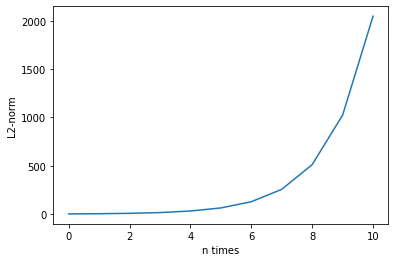

In [6]:
plt.plot(norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')
# Gradient Exploding

Text(0, 0.5, 'L2-norm')

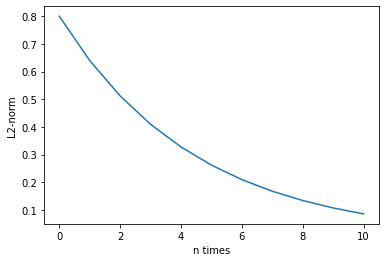

In [7]:
W = tf.ones([2, 2]) * 0.4
eigenvalues = tf.linalg.eigh(W)[0]  # 获取特征值
# 多次连乘
val = [W]
for _ in range(10):
    val.append(val[-1]@W)

# L2范数
norm = list(map(lambda x:tf.norm(x).numpy(), val))
plt.plot(norm)
plt.xlabel('n times')
plt.ylabel('L2-norm')
# Gradient Vanishing

### 梯度裁剪(Gradient Clipping)

梯度爆炸可以通过梯度裁剪(Gradient Clipping)的方式在一定程度上的解决

1. 简单裁剪, 直接对张量的数值进行限幅

In [8]:


a = tf.random.uniform([2, 2])
a

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.2983166 , 0.3531624 ],
       [0.7991512 , 0.90950274]], dtype=float32)>

In [9]:
tf.clip_by_value(a, 0.4, 0.6)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.4, 0.4],
       [0.6, 0.6]], dtype=float32)>

2. 限制梯度张量W的范数
$$W' = \frac {W}{||W||_2} \cdot max$$

In [10]:
a = tf.random.uniform([2, 2]) * 5
a

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[3.6038704, 2.7221942],
       [4.963417 , 2.7399235]], dtype=float32)>

In [11]:
b = tf.clip_by_norm(a, 5)
b

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2.4859385, 1.8777611],
       [3.4237494, 1.8899906]], dtype=float32)>

In [12]:
tf.norm(a), tf.norm(b)

(<tf.Tensor: shape=(), dtype=float32, numpy=7.248511>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>)

3. 全局范数裁剪, 考虑所有参数的梯度的范数, 等比例缩放

$$global\_norm = \sqrt{\sum_i ||W^{i}||^2_2}$$

$$W^{(i)} = \frac {W^{(i)} \cdot max\_norm}{max(global\_norm, max\_norm)}$$

In [13]:
w1 = tf.random.normal([3, 3])
w2 = tf.random.normal([3, 3])
global_norm = tf.sqrt(tf.norm(w1) ** 2 + tf.norm(w2) ** 2)
global_norm

<tf.Tensor: shape=(), dtype=float32, numpy=5.3088274>

In [14]:
tf.clip_by_global_norm?

Signature: tf.clip_by_global_norm(t_list, clip_norm, use_norm=None, name=None)
Docstring:
Clips values of multiple tensors by the ratio of the sum of their norms.

Given a tuple or list of tensors `t_list`, and a clipping ratio `clip_norm`,
this operation returns a list of clipped tensors `list_clipped`
and the global norm (`global_norm`) of all tensors in `t_list`. Optionally,
if you've already computed the global norm for `t_list`, you can specify
the global norm with `use_norm`.

To perform the clipping, the values `t_list[i]` are set to:

    t_list[i] * clip_norm / max(global_norm, clip_norm)

where:

    global_norm = sqrt(sum([l2norm(t)**2 for t in t_list]))

If `clip_norm > global_norm` then the entries in `t_list` remain as they are,
otherwise they're all shrunk by the global ratio.

If `global_norm == infinity` then the entries in `t_list` are all set to `NaN`
to signal that an error occurred.

Any of the entries of `t_list` that are of type `None` are ignored.

This is the c

In [15]:
(ww1, ww2), global_norm = tf.clip_by_global_norm([w1, w2], 2)  # 总范数限制为2

In [16]:
global_norm

<tf.Tensor: shape=(), dtype=float32, numpy=5.3088274>

In [17]:
ww1, ww2

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[-0.2733137 ,  0.52680326, -0.05450167],
        [ 0.25195938,  0.9994291 , -0.3489722 ],
        [-0.5890649 , -0.07980286, -0.27893683]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[-0.31072882, -0.15228777, -0.6818291 ],
        [-0.2219694 ,  0.8624417 , -0.51475066],
        [-0.12010892, -0.23439114,  0.56344295]], dtype=float32)>)

In [18]:
global_norm2 = tf.sqrt(tf.norm(ww1) ** 2 + tf.norm(ww2) ** 2)
global_norm2

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

在网络训练时，梯度裁剪一般在计算出梯度后，梯度更新之前进行

### 处理梯度弥散
对于梯度弥散现象，可以通过增大学习率、减少网络深度、添加 Skip Connection 等一系列的措施抑.

减少网络深度可以减轻梯度弥散现象, 但会影响表达能力.

使用深度残差网络